To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.
* [**NEW**] We make Gemma 6 trillion tokens **2.5x faster**! See our [Gemma notebook](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)
* [**NEW**] We make Llama-3 15 trillion tokens **2x faster**! See our [Llama-3 notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit", # New Google 6 trillion tokens model 2.5x faster!
    "unsloth/gemma-2b-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/mistral-7b-v0.3", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.10.7: Fast Mistral patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.9. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Unsloth: We fixed a gradient accumulation bug, but it seems like you don't have the latest transformers version!
Please update transformers, TRL and unsloth via:
`pip install --upgrade --no-cache-dir --no-deps unsloth transformers git+https://github.com/huggingface/trl.git`


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.10.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `ChatML` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [ ]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("All_3_Bug_report_elements")
df = pd.DataFrame(dataset['train'])

# Save to CSV
df.to_csv('dataset.csv', index=False)
# Save to CSV


README.md:   0%|          | 0.00/946 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/882k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3029 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
alpaca_prompt = """You are an assistant specialized in generating detailed bug reports.

### Instruction:
Please create a bug report that includes the following sections:
1. **Steps to Reproduce (S2R)**: Detailed steps to replicate the issue.
2. **Expected Result (ER)**: What you expected to happen.
3. **Actual Result (AR)**: What actually happened.
4. **Additional Information**: Include relevant details such as software version, build number, environment, etc.

If any of these sections are missing from the provided summary, explicitly notify the user which information is missing.

### Context:
{Summary}

### Response:
"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    # Fixed instruction string (same for all examples)
    # instruction = "Whenever you get this paragraph type of input, you have to give the output in this particular format. Strictly tell me if some info is missing and any additional info such as version and build number should be written at the end in the seperate heading"

    inputs = examples["Summary"]
    steps_to_reproduce = examples["Steps to Reproduce"]
    expected_res = examples["Expected_Res"]
    actual_res = examples["Actual_Res"]
    Additional_info =  examples["Additional_info"]

    texts = []
    for input, step, expected, actual,Additional_info in zip(inputs, steps_to_reproduce, expected_res, actual_res,Additional_info):
      # Construct the additional information section
        additional_info = f"**Additional Information:**\n- {Additional_info}"

        # Combine all sections into the response
        response = (
            f"**Steps to Reproduce:**\n{step}\n\n"
            f"**Expected Result (ER):**\n{expected}\n\n"
            f"**Actual Result (AR):**\n{actual}\n\n"
            f"{additional_info}"
        )
        output = response
        # Ensure the output does not exceed 2000 characters
        trimmed_output = output[:2000 - len(EOS_TOKEN)]  # Adjust the slice if needed to fit EOS_TOKEN
        formatted_text = alpaca_prompt.format(input, trimmed_output) + EOS_TOKEN
        texts.append(formatted_text)

    return {"text": texts}


In [ ]:
# alpaca_prompt = """You are an assistant specialized in generating detailed bug reports.

# ### Instruction:
# Please create a bug report that includes the following sections:
# 1. **Steps to Reproduce (S2R)**: Detailed steps to replicate the issue.
# 2. **Expected Result (ER)**: What you expected to happen.
# 3. **Actual Result (AR)**: What actually happened.
# 4. **Additional Information**: Include relevant details such as software version, build number, environment, etc.

# If any of these sections are missing from the provided summary, explicitly notify the user which information is missing.

# ### Context:
# {Summary}

# ### Response:
# """

# EOS_TOKEN = tokenizer.eos_token

# def formatting_prompts_func(batch):
#     # Extracting fields from batch
#     inputs = batch["Summary"]
#     steps_to_reproduce = batch["Steps to Reproduce"]
#     expected_res = batch["Expected_Res"]
#     actual_res = batch["Actual_Res"]

#     # List to store the formatted texts
#     texts = []

#     # Generate additional info placeholder
#     additional_info = "Build Number 1"

#     for input, step, expected, actual in zip(inputs, steps_to_reproduce, expected_res, actual_res):
#         # Construct the additional information section
#         additional_section = f"**Additional Information:**\n- {additional_info}"

#         # Combine all sections into the response
#         response = (
#             f"**Steps to Reproduce (S2R):**\n{step}\n\n"
#             f"**Expected Result (ER):**\n{expected}\n\n"
#             f"**Actual Result (AR):**\n{actual}\n\n"
#             f"{additional_section}"
#         )

#         # Format the full prompt
#         formatted_text = alpaca_prompt.format(Summary=input) + response + EOS_TOKEN
#         texts.append(formatted_text)

#     return {"text": texts}

# # Reloading dataset and mapping function
# dataset = load_dataset("Splitted_Bug_report_Final_new_dataset_2024", split="train")
# dataset = dataset.map(formatting_prompts_func, batched=True)


README.md:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.66M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/490k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/476k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2526 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/316 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/316 [00:00<?, ? examples/s]

Map:   0%|          | 0/2526 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Splitted_Bug_report_Final_new_dataset_2024", split="train")
dataset = dataset.map(formatting_prompts_func, batched=True)

In [ ]:
dataset['text'][2]

'You are an assistant specialized in generating detailed bug reports. \n\n### Instruction:\nPlease create a bug report that includes the following sections:\n1. **Steps to Reproduce (S2R)**: Detailed steps to replicate the issue.\n2. **Expected Result (ER)**: What you expected to happen.\n3. **Actual Result (AR)**: What actually happened.\n4. **Additional Information**: Include relevant details such as software version, build number, environment, etc.\n\nIf any of these sections are missing from the provided summary, explicitly notify the user which information is missing.\n\n### Context:\nHere is a rewritten version of the attachment in paragraph format:\n\nWhen debugging a page with different response content based on the presence of a GET parameter, we expect to see distinct code displayed by the debugger depending on whether or not the parameter is present in the URL. For example, if we visit `http://example.com/index?var=xxxx`, the debugger should display the code for `http://exam

In [ ]:
from datasets import load_dataset
eval_dataset = load_dataset("Splitted_Bug_report_Final_new_dataset_2024", split="test")
eval_dataset = dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/2526 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**** Unsloth: Please use our fixed gradient_accumulation_steps by updating transformers, TRL and Unsloth!
`pip install --upgrade --no-cache-dir --no-deps unsloth transformers git+https://github.com/huggingface/trl.git`


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,526 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 8
\        /    Total batch size = 16 | Total steps = 471
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
5,No log,0.708857
10,0.735300,0.708212
15,0.735300,0.706462
20,0.731100,0.701825
25,0.700400,0.697271
30,0.700400,0.693363
35,0.675200,0.690779
40,0.671700,0.688114
45,0.671700,0.683490
50,0.701600,0.681857


Step,Training Loss,Validation Loss
5,No log,0.708857
10,0.735300,0.708212
15,0.735300,0.706462
20,0.731100,0.701825
25,0.700400,0.697271
30,0.700400,0.693363
35,0.675200,0.690779
40,0.671700,0.688114
45,0.671700,0.683490
50,0.701600,0.681857


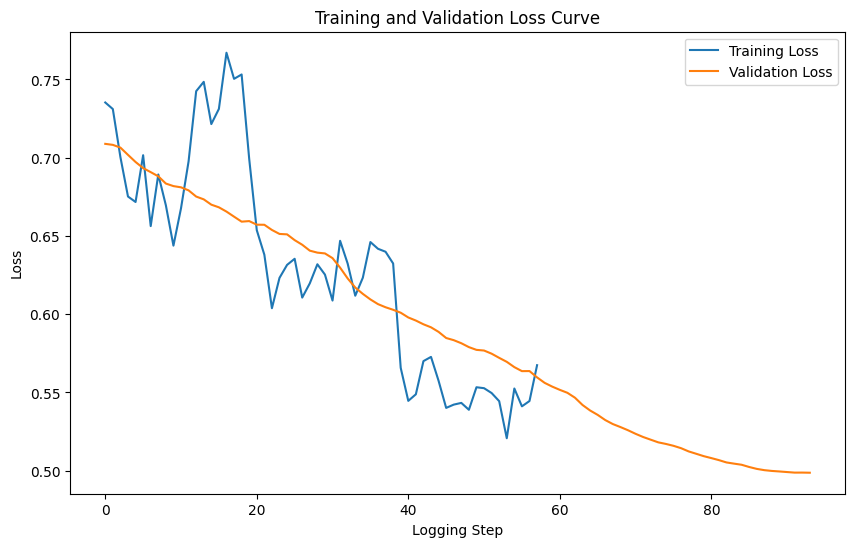

In [ ]:

import matplotlib.pyplot as plt
from trl import SFTTrainer
from transformers import TrainingArguments, TrainerCallback

# Custom callback to track training and validation losses
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

# Initialize the loss history callback
loss_history = LossHistoryCallback()

# Set up training arguments with optimizations
args = TrainingArguments(
    output_dir="unsloth-test",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=10,
    # max_steps=100,
    num_train_epochs=8,
    learning_rate=2e-4,
    logging_steps=8,
    evaluation_strategy="steps",
    eval_steps=5,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    gradient_checkpointing=True,
    optim="adamw_8bit",
    seed=3407
)

# Create the trainer
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    eval_dataset=eval_dataset.select(range(min(len(eval_dataset), 200))),  # Smaller eval dataset
    dataset_text_field="text",
    max_seq_length=2048,
    tokenizer=tokenizer,
    callbacks=[loss_history]
)

# Start training
trainer.train()

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(loss_history.train_losses, label='Training Loss')
plt.plot(loss_history.eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Logging Step')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt_template.format(
        "Generate a bug report in the specified format, including steps to reproduce, expected result, and actual result and additional information if any.", # instruction
        "I opened my browser went to facebook.com, clicked on forgot password, clicked on get otp and the browser got crashed, I dont know why, ideally it should send otp, but it crashed.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 200, use_cache = True)
tokenizer.batch_decode(outputs)

['<s> ### Instruction:\nGenerate a bug report in the specified format, including steps to reproduce, expected result, and actual result.\n\n### Bug Report Summary:\nGenerate a bug report in the specified format, including steps to reproduce, expected result, and actual result and additional information if any.\n\n### Bug Report:\nSteps to Reproduce:\nExpected Result:\nActual Result:\nAdditional Information:\n\n### Response:\n**Steps to Reproduce**\n\nHere is the extracted section:\n\n**Steps to Reproduce**\n\n1. Open a new tab.\n2. Type "about:config" in the address bar.\n3. Search for "browser.preferences.search".\n4. Set its value to true.\n5. Restart the browser.\n6. Open about:preferences.\n7. Type "firefox" in the search field.\n\n**Expected Result**\n\nThe section titled "Expected Results" is:\n\n* The search results are displayed.\n\n**Actual Result**\n\nHere is the extracted section:\n\n**Actual Results**\n\nThe search results are not displayed.\n\n**Additional Information**\n\

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [1]:
model.save_pretrained("New_add_Mistral_Bug") # Local saving
tokenizer.save_pretrained("New_add_Mistral_Bug")
model.push_to_hub("Mistral_Bug", token = "token") # Online saving
tokenizer.push_to_hub("Mistral_Bug", token = "token") # Online saving

NameError: name 'model' is not defined

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q5_k_m", token = "")